# The Product Pricer Continued

A model that can estimate how much something costs, from its description.

## Data Curation Part 2

Today we'll extend our dataset to a greater coverage, and craft it into an excellent dataset for training.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## The Lite dataset

This notebook creates a smaller dataset for Home Appliances only, to keep training fast and costs low. You may need to update names of future notebooks to reflect that you have built the "lite" dataset not the full dataset.

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

## The ItemLoader code

Look in loaders.py - there's some useful code to make life easier for us

## Now to SCALE UP

Let's look at all datasets of all the items that you might find in a large home retail store - electrical, electronic, office and related, but not clothes / beauty / books.

In [5]:
dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [6]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


100%|██████████| 95/95 [00:21<00:00,  4.36it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins


In [7]:
print(f"A grand total of {len(items):,} items")

A grand total of 28,625 items


In [21]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({
    'figure.figsize': (15, 6),
    'font.size': 10,
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial', 'Helvetica'],
})
%matplotlib inline

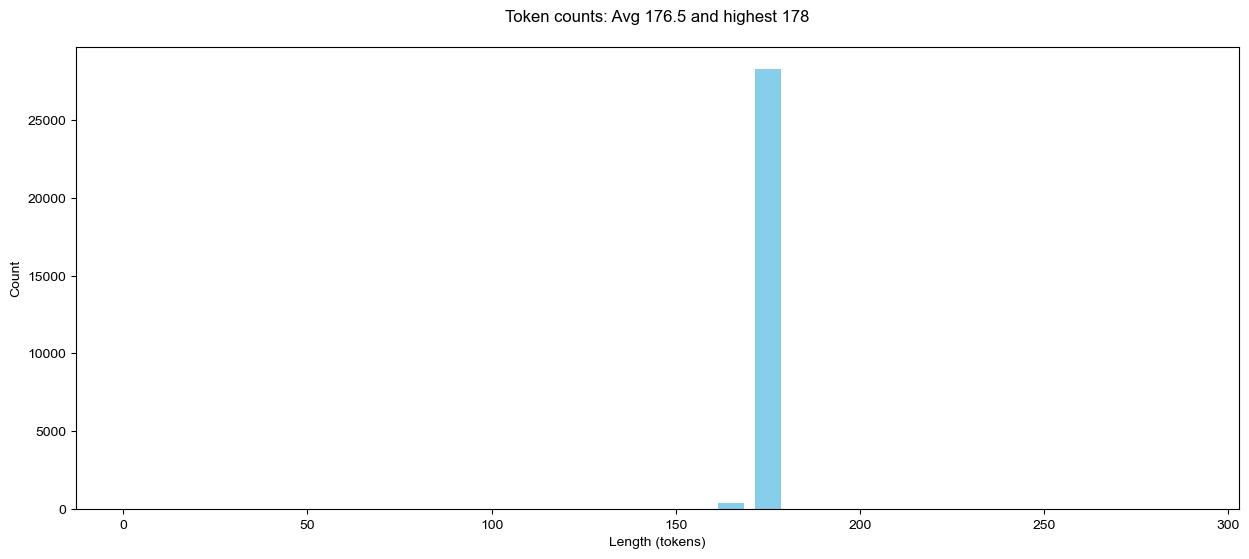

In [22]:
# Plot the distribution of token counts again

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

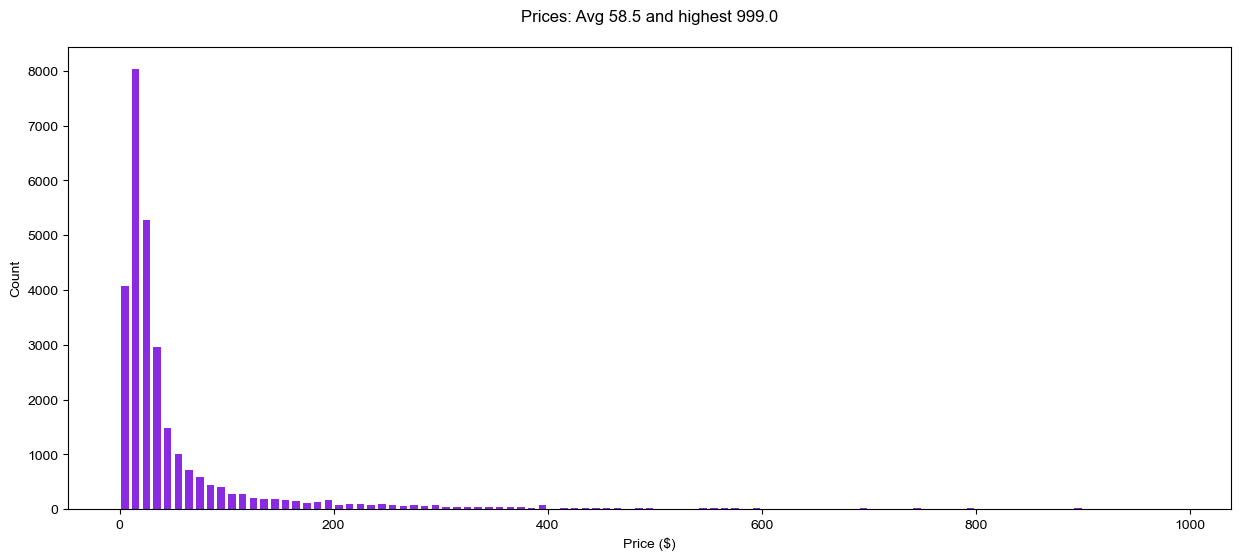

In [23]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

# Dataset Curated!

We've crafted an excellent dataset.

Let's do some final checks

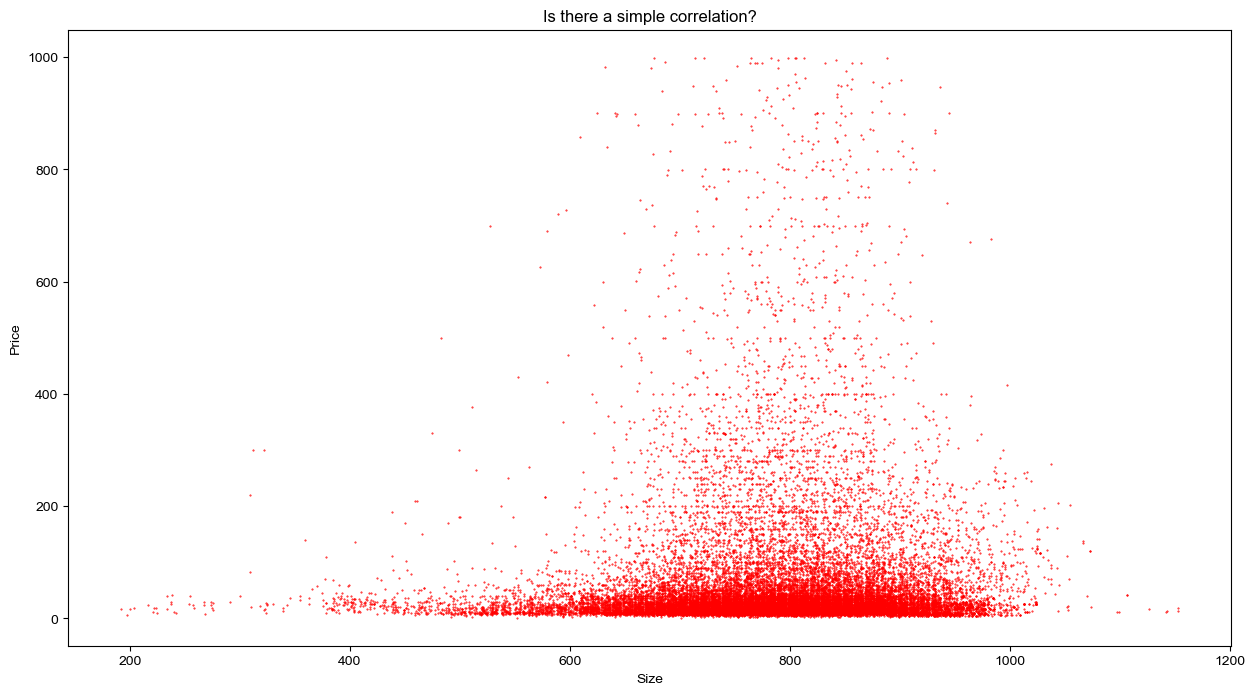

In [24]:
# How does the price vary with the character count of the prompt?

sample = items

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Add labels and title
plt.xlabel('Size')
plt.ylabel('Price')
plt.title('Is there a simple correlation?')

# Display the plot
plt.show()

In [25]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [26]:
report(sample[50])

How much does this cost to the nearest dollar?

2-Pack Premium Stainless Steel Washing Machine Hoses - 4 FT No-Lead Burst Proof Water Inlet Supply Lines - Universal Connection - 10 Year Warranty
2-Pack 4FT Stainless Steel Braided Washing Machine Hoses with Universal 3/4 Connector. Key Features Two layers PVC core with reinforced nylon in between and 304 stainless steel braided outer cover for high performance and durable water supply applications Two layers PVC core with reinforced nylon in between and 304 stainless steel braided outer cover for high performance and durable water supply applications Universal connector fits all washing machines Universal connector fits all washing machines Comply with following standards ASME NSF/ANSI 61,372 Comply with following standards ASME NSF/ANSI 61,372 While typical water supply pressure ranges 50 - 80

Price is $20.00
[482, 220, 1490, 271, 7117, 374, 400, 508, 13, 410]
[' -', ' ', '80', '\n\n', 'Price', ' is', ' $', '20', '.', '00']


## Observation

An interesting thing about the Llama tokenizer is that every number from 1 to 999 gets mapped to 1 token, much as we saw with gpt-4o. The same is not true of qwen2, gemma and phi3, which all map individual digits to tokens. This does turn out to be a bit useful for our project, although it's not an essential requirement.

# Finally

It's time to break down our data into a training, test and validation dataset.

It's typical to use 5%-10% of your data for testing purposes, but actually we have far more than we need at this point. We'll take 25,000 points for training, and we'll reserve 2,000 for testing, although we won't use all of them.


In [27]:
random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Divided into a training set of {len(train):,} items and test set of {len(test):,} items")

Divided into a training set of 25,000 items and test set of 2,000 items


In [28]:
print(train[0].prompt)

How much does this cost to the nearest dollar?

Gefu Coffee Filter Sandro, Size 4, Accessories, Porcelain, Prolonged Outlet, 16020
With the porcelain coffee filter, hand-brewed coffee is a pleasure, not only for nostalgics. Simply pour some water over the ground coffee so that it swells and the flavours dissolve. Then fill the filter to the brim and wait until the coffee has run through completely. Repeat this process until the cup or jug ​​is full, and then. Enjoy The extended socket ensures optimum hold on almost every vacuum jug. For filters standard size separately) Dimensions H 145,? 130?mm Dishwasher-safe Product guaranteed for Dimensions 6.42 x 6.22 x 6.38 inches, Weight 1.41 pounds, Manufacturer G

Price is $39.00


In [15]:
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


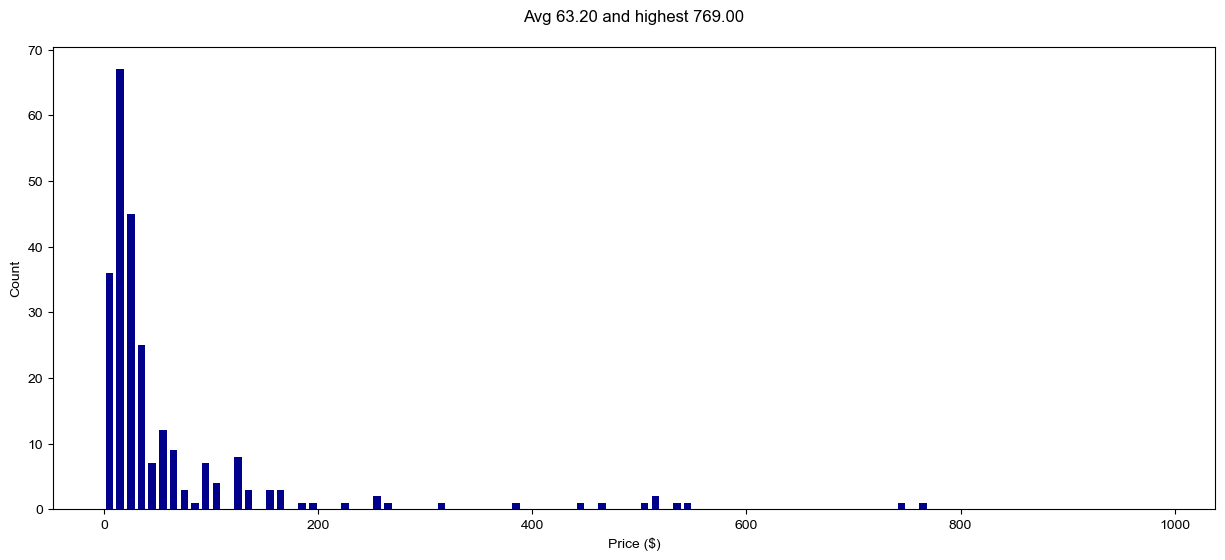

In [29]:
# Plot the distribution of prices in the first 250 test points

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finally - upload your brand new dataset

Convert to prompts and upload to HuggingFace hub

In [30]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [31]:
# Create a Dataset from the lists

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [32]:
DATASET_NAME = "AJ14314/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

c:\Users\anand\.conda\envs\llm_learnings\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\anand\.cache\huggingface\hub\datasets--AJ14314--lite-data. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


CommitInfo(commit_url='https://huggingface.co/datasets/AJ14314/lite-data/commit/7d43062a0281cb896d57527419f9591fa5802c69', commit_message='Upload dataset', commit_description='', oid='7d43062a0281cb896d57527419f9591fa5802c69', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/AJ14314/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='AJ14314/lite-data'), pr_revision=None, pr_num=None)

In [33]:
# One more thing!
# Let's pickle the training and test dataset so we don't have to execute all this code next time!

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)

## Todos for you:

- Investigate the dataset more!
- Confirm that the tokenizer tokenizes all 3 digit prices into 1 token